# 3 - Testing Crystal Overlaps (Symmetric Metric)

This notebook creates a bulk of the simulated data for the Toy model section of the paper.

Here we test overlaps in Nano Cry with increasing overlaps

Carter Francis | csfrancis@wisc.edu | 2024-01-15

In [ ]:
import numpy as np
from skimage.draw import disk
import matplotlib.pyplot as plt

from orix.crystal_map import Phase
from orix.quaternion import Rotation
import hyperspy.api as hs

from utils import *

## Stretching to __Very Complex__ Systems

Some times it is necessary to retain good performance to very complicated systems (such as looking at amorphous materials).  In this case we can consider a three angle seperation.  The basic idea is that highly symmetric diffraction patterns should have at least 3 diffraction vectors which have some angle $\phi$  such that for three diffraction vectors they should be seperated by $\phi$, $\phi$, and $2\phi$.

The figure below shows an example of this with 4 fold symmetry. 

For complicated systems this metric is a good way to determine if diffraction vectors belong to the __same__ crystal becuase it is fairly unlikely that three vectors will end up with such a high degree of angular symmetry by chance. 

The figure below shows some large number of crystals filtered for those that have some high degree of angular symmetry as well as the crystals found using the 3 angle metric. 

We can also see how this preforms by plotting the histogram of angles found.  Ideally only symmetries in the crystal would be shown.  So in this case 4 and 6 fold symmetries. 

In [113]:
s = CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=20) 

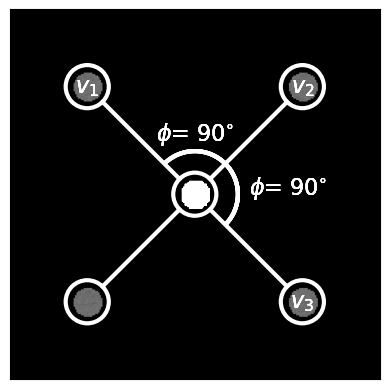

In [158]:
fig, ax = plt.subplots(1,1)
s.plot_example_dp(ax=ax,
                  rotation=(0,0,45),
                  threshold=0.2,
                  num_electrons=10,
                  reciprocal_radius=.6,
                  pixels=256,
                  disk_r=10,cmap="gray"
                 )
ax.set_xticks([])
ax.set_yticks([])

sim = s.generator.calculate_ed_data(s.strucuture,
                                    rotation=(0,0,45),
                                    reciprocal_radius=.6,)

from matplotlib.patches import Circle, Arc
from matplotlib.lines import Line2D
circle_rad=0.07
for c in sim.coordinates:
    cir = Circle(xy=c, radius=circle_rad,facecolor="none", lw=3, edgecolor="w")
    ax.add_patch(cir)

    if not np.sum(np.abs(c[:2]))<0.01:
        ang = np.arctan2(c[1], c[0])
        line_start =  [np.sin(ang)*circle_rad,
                       np.cos(ang)*circle_rad]
        signs = np.sign(c[:2]) * np.sign(line_start)
        line_end = c[:2] - line_start * signs                   
        l = Line2D([line_end[0], line_start[1]], [line_end[1], line_start[0]], color="w", lw=3)
        ax.add_line(l)
    
    v1, v2, v3 = sim.coordinates[3],sim.coordinates[4], sim.coordinates[1]
    ax.text(v1[0],v1[1],"$v_1$", color="w", size=16,horizontalalignment="center",verticalalignment= "center")
    ax.text(v2[0],v2[1],"$v_2$", color="w", size=16,horizontalalignment="center",verticalalignment= "center" )
    ax.text(v3[0],v3[1],"$v_3$", color="w", size=16,horizontalalignment="center", verticalalignment= "center")



    
    arc = Arc(xy=(0,0), width=circle_rad*4, height=circle_rad*4,angle=-45,theta1=0, theta2=180,  color="w", lw=3)
    ax.add_patch(arc)
    ax.text(circle_rad*2.5,0,"$\phi$= 90$^{\circ}$", color="w", size=16)
    ax.text(0,circle_rad*2.5,"$\phi$= 90$^{\circ}$", color="w", size=16,horizontalalignment="center" )

fig.savefig("Figures/Figure4-ThreeVectorExp.png")

## Comments on Glasses:

For an off the cuff calculation if we assume that each strucuture in glass is 1 nm then in a 10 nm x 10 nm x 10nm cube there would be __at most__ 1000 strucutures in the glass. That is about equivlent to the 1200 crystals example. The problem is that at this point we get perfect recall only like 40% of the time.  This is also assuming an ideally diffracting system (which glasses are far from). So a more conservitivate estimate would be around 20%.  The result is that any strucuture could be indentified based on random rotations.  Thing spiral from there if you consider the fact that you also get "false-positives" and there is no ground truth to indentify if something is false.

But we can also just take our metric from above and it fixes the problems from above by __Excluding__ most of the extra stuff and only really focusing on the parts we are interested in (the highly symmetric diffraction patterns :))

In [165]:
def reduced_subtract(min_vector, v2):
    return np.abs(v2-np.round(v2/min_vector)*min_vector)
reduced_subtract(60, 120)

0.0

In [198]:
np.all(True)

True

In [199]:
import itertools
def get_filtered_combinations(pks,
                              num,
                              radial_index=0,
                              angle_index=1,
                              intensity_index=2,
                              intensity_threshold=None,
                              min_angle=None, 
                              min_k=None
                              ):
    """
    Creates combinations of `num` peaks but forces at least one of the combinations to have
    an intensity higher than the `intensity_threshold`.
    This filter is useful for finding high intensity features but not losing lower intensity
    paired features which contribute to symmetry etc.
    """
    angles = pks[:,angle_index]
    k = pks[:, radial_index]

    angle_combos = list(itertools.combinations(angles,num))
    k_combos = list(itertools.combinations(k,num))
    # Filtering out combinations with only diffraction from vectors below the intensity threshold
    if intensity_threshold is not None:
        intensity_combos = itertools.combinations(intensity, num)
        has_min_intensity = np.array([any(np.array(i)>intensity_threshold) for i in intensity_combos])
    else:
        has_min_intensity=True
    # Filtering out combinations where there are two peaks close to each other
    if min_angle is not None:
        above_angle = np.array([all([np.abs(np.subtract(*c))>min_angle for c in itertools.combinations(a,2)])
                         for a in angle_combos])
    else:
        above_angle =True
    # Filtering out combinations of diffraction vectors at different values for k.
    if min_k is not None:
        in_k_range = np.array([np.mean(np.abs(np.subtract(np.mean(k), k))) < k_threshold for k in k_combos])
    else:
        in_k_range=True
    
    in_combos = above_angle*has_min_intensity*in_k_range
    if np.all(in_combos):
        combos = angle_combos
        combos_k = [np.mean(ks) for ks in k_combos]

    else:

        combos = [c for c, in_c in zip(angle_combos,in_combos) if in_c]
        combos_k = [np.mean(ks) for ks, in_range in zip(k_combos,in_combos) if in_range]
    return combos, combos_k



import itertools
def get_three_angles(pks,
                     k_index=0,
                     angle_index=1,
                     intensity_index=2,
                     intensity_threshold=None,
                     accept_threshold=0.05,
                     k_threshold=.1,
                     include_multi=False,
                     return_min=True,
                     multi=True,
                     min_angle=None,
                    ):
    """
    This function takes the angle between three points and determines the angle between them,
    returning the angle if it is repeated using the `accept_threshold` to measure the acceptable
    difference between angle a and angle b
           o
           |
           |_   angle a
           | |
           x--------o
           |_|
           |    angle b
           |
           o
    """
    three_angles = []
    min_angles = []
    combos, combo_k = get_filtered_combinations(pks,3,
                                           angle_index=angle_index,
                                           intensity_index=intensity_index,
                                           intensity_threshold=intensity_threshold,min_angle=min_angle)
    for c,k in zip(combos, combo_k):
        angular_seperations = get_angles(c)
        try:
            min_ind = np.argmin(angular_seperations)
            min_sep = angular_seperations[min_ind]
            angular_seperations = np.delete(angular_seperations, min_ind)
            if multi: # test to see if any of the angles are multiples of each other
                remain = [reduced_subtract(min_sep, a) for a in angular_seperations ]
                remain = [np.abs(f)<accept_threshold for f in remain]
                is_symetric = np.all(remain)
            else:   
                is_symetric = np.any(np.abs((angular_seperations - min_sep))<accept_threshold)
            if is_symetric:
                if not return_min:
                    for a in angular_seperations:
                        three_angles.append(a)
                    three_angles.append(min_sep)
                else:
                    min_angle = np.min(c)
                    num_times = np.round(min_angle/min_sep)
                    three_angles.append([min_angle, min_sep, np.abs(min_angle - (num_times*min_sep)),k])
        except(ValueError):
            print("error")
            print(c)
            print(combos)
            pass
    if len(three_angles)==0:
        three_angles = np.empty((0,4))
    return np.array(three_angles)

def unwrap(pks):
    if len(pks)==0:
        return np.empty((0,3))
    r = np.linalg.norm(pks[:,:2], axis=1) # ignore the intensity
    theta = np.arctan2(pks[:,0],pks[:,1])
    return np.stack((r,theta, pks[:,2]), axis=1)
def filter_mag(z, min_mag, max_mag):
    norm = np.linalg.norm(z[:,:2], axis=1)
    in_range= norm<max_mag*(norm>min_mag)
    return z[in_range]

import numpy as np
from copy import deepcopy
def angles_to_markers(angles,
                      signal,
                      polar=True,
                      return_marker=False,
                      **kwargs):
    """ Convert a set of angles to markers.
    
    Angles are set as [Initial Position, Angular Seperation, Reduced Position, k]
    
    """
    new_angles = deepcopy(angles.data)
    
    # Sorting based on navigation position 
    x_axis, y_axis = signal.axes_manager.navigation_axes
    new_angles[:,0]= np.round((new_angles[:,0]-x_axis.offset)/x_axis.scale)
    new_angles[:,1]= np.round((new_angles[:,1]-y_axis.offset)/y_axis.scale)
    ind = np.lexsort((new_angles[:,1],new_angles[:,0]))
    sorted_peaks = new_angles[ind]
    x,y = signal.axes_manager.signal_axes
    # Create Ragged arrays
    shape = signal.axes_manager.navigation_shape
    by_ind_peaks = np.empty(shape,dtype=object)
    by_ind_colors = np.empty(shape,dtype=object)
    num_labels = np.max(new_angles[:,-1])
    # Random Colors
    colors_by_index = np.random.random((int(num_labels+1),3))*0.9 # (Stay away from white)
    colors_by_index = np.vstack((colors_by_index, [1,1,1]))
    # Serach sorted for speed 
    low_x_ind = np.searchsorted(sorted_peaks[:,0],range(0,shape[0]), side="left")
    high_x_ind = np.searchsorted(sorted_peaks[:,0],range(1,shape[0]+1), side="left")
    for i, (lo_x,hi_x) in enumerate(zip(low_x_ind, high_x_ind)):
        x_inds = sorted_peaks[lo_x:hi_x]
        low_y_ind = np.searchsorted(x_inds[:,1],range(0,shape[1]), side="left")
        high_y_ind = np.searchsorted(x_inds[:,1],range(1,shape[1]+1), side="left")
        for j, (lo_y,hi_y) in enumerate(zip(low_y_ind, high_y_ind)):
            # Get positions
            initial_theta = x_inds[lo_y:hi_y, 2]
            angle_seperation = x_inds[lo_y:hi_y, 3]
            k = x_inds[lo_y:hi_y, 5]
            # make optional for unlabeled...
            labels = np.array(x_inds[lo_y:hi_y, -1], dtype=int)
            #Compute angles based on 3 angle seperation
            angles = [initial_theta+angle_seperation*i for i in [0,1,2]]
            y_values = np.hstack([np.cos(a)*k for a in angles])
            x_values = np.hstack([np.sin(a)*k for a in angles])
            labels = np.hstack((labels, labels, labels))
            by_ind_peaks[i,j] = np.stack((y_values, x_values), axis=1)
            by_ind_colors[i,j] = colors_by_index[labels]
    return by_ind_peaks, by_ind_colors, colors_by_index

In [300]:
def combinations(n, r):
    return np.math.factorial(n)/(np.math.factorial(r)*np.math.factorial(n-r))

## Generating the Data on Recall for Symmetry Filtered Data

In [ ]:
import hyperspy.api as hs
from dask_image.ndfilters import gaussian_filter
from sklearn.cluster import DBSCAN
hs.set_log_level("ERROR")
hs.preferences.General.show_progress_bar=False
for i in range(6):
    num_crystals = [500, 1000,1500, 2000, 3000]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("AllResults/recall_sym_crystals"+str(i)+".txt","w+") as f:
        f.write("num_crystals, recall, false positives \n")

        for s, num_crystal in zip(simulations, num_crystals):
            import hyperspy.api as hs
            from scipy.spatial import KDTree
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))

            filtered = signal.filter(gaussian_filter,
                                     sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5,
                                                    subtract_min=False,
                                                        show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0

            signal.axes_manager.signal_axes[0].offset=-1
            signal.axes_manager.signal_axes[1].offset=-1
            signal.axes_manager.signal_axes[1].scale=1/32
            signal.axes_manager.signal_axes[0].scale=1/32

            pks = template.find_peaks(threshold_abs=0.5,
                                      interactive=False,
                                      show_progressbar=False,
                                      get_intensity=True)
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks,
                                                 center= (32, 32, 0),
                                                 calibration=(1/32,1/32, 1))

            filt = vect.map(filter_mag,
                            min_mag= .05,
                            max_mag = .85,
                            show_progressbar=False, inplace=False)
            
            pol = filt.to_polar()
            angles = pol.get_angles(accept_threshold=0.75, min_k=.1)

            angles.compute()
            flat_angles = angles.flatten_diffraction_vectors()
            clusterd_angles = flat_angles.cluster(DBSCAN(min_smaples=5, eps=1),
                                                  column_scale_factors=(1.5,1.5, 1,1),
                                                  min_vectors=90)

            means = clusterd_angles.map_vectors(column_mean, columns=[0,1,2,3,4,5], dtype=float, shape=(6,))

            filtered_coords = s.get_coords(.1,0.85)
            filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
            filtered_coords = [c for c in filtered_coords if len(c)>1]

            ground_truth_angles = []
            for c in filtered_coords:
                unwrapped = unwrap(c)
                ground_truth_angles.append(get_three_angles(unwrapped,accept_threshold=0.1,  k_threshold=.1))
            # Get the center for only those vectors with some high degree of symmetry
            filtered_centers = np.array([c for c, gt in zip(filtered_centers, ground_truth_angles) if len(gt)>0])
            min_angle = np.array([np.min(a[:,1]) for a in ground_truth_angles if len(a)>0])

            symmetries = np.hstack([filtered_centers, min_angle[:,np.newaxis]]) # x, y, phi
            filtered_mean = means[:, (0,1,3)][np.logical_not(np.any(np.isnan(means[:, (0,1,3)]), axis=1))]
            recall = test_recall(symmetries,
                                 filtered_mean,
                                 indexes2=np.array((2,)), 
                                 r1=10, 
                                 r2=.05,)

            false_positives = test_false_positives(symmetries,
                                                   filtered_mean,
                                                   indexes2=np.array((2,)), 
                                                   r1=10, 
                                                   r2=.05,)
            print("Recall", recall)
            print("False Positives", false_positives)
            f.write(str(num_crystal)+", " + str(recall)+", "+ str(false_positives)+"\n")
        
        

## Plotting Symmetry Filtered Data

In [36]:
num_crystals = [500, 1000,1500, 2000, 3000 ]
simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]

In [37]:
sym_recall = [np.loadtxt("AllResults/recall_sym_crystals"+str(i)+".txt", delimiter=",", skiprows=1) for i in range(6)]
mean_sym_recall = np.mean(sym_recall, axis=0)
std_sym_recall = np.std(sym_recall, axis=0)

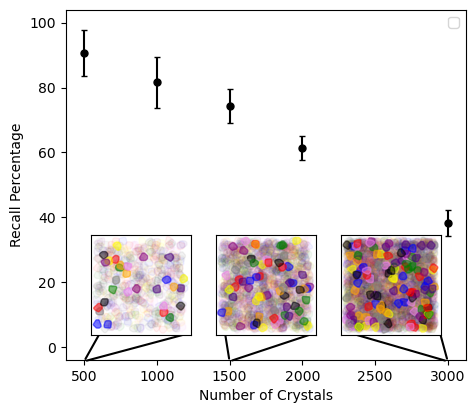

In [38]:
fig = plt.figure(figsize=(5,5))

axs = fig.add_axes((.15,.15, 0.8,0.7))
axs.errorbar(mean_sym_recall[:,0],
             mean_sym_recall[:,1]*100,
             std_sym_recall[:,1]*100,
             capsize=2, color="black",ls="none",
             marker="o", markersize=5,)


axs.set_xlabel("Number of Crystals")
axs.set_ylabel("Recall Percentage")
axs.set_ylim(-4,104)

axs2 = fig.add_axes((.2,.2, 0.2,0.2))

axs3 = fig.add_axes((.45,.2, 0.2,0.2))

axs4 = fig.add_axes((.7,.2, 0.2,0.2))

for ax in [axs2,axs3,axs4]:
    ax.set_xticks([])
    ax.set_yticks([])

simulations[0].plot_real_space(ax=axs2, alpha=0.05)
simulations[0].plot_real_space(ax=axs2, remove_non_symmetric=True, alpha=0.5)
simulations[2].plot_real_space(ax=axs3, alpha=0.05)
simulations[2].plot_real_space(ax=axs3, remove_non_symmetric=True, alpha=0.5)
simulations[-1].plot_real_space(ax=axs4, alpha=0.05)
simulations[-1].plot_real_space(ax=axs4, remove_non_symmetric=True, alpha=0.5)

for a, i,c in zip([axs2, axs3, axs4], [0,2,-1], corners):
    axs.annotate("", xy=(num_crystals[i],-4.5), xytext=(c, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    axs.annotate("", xy=(num_crystals[i],-4.5), xytext=(c+0.18, .16), xycoords="data",
                 textcoords="figure fraction",
                 arrowprops=dict(facecolor='black',arrowstyle="-", lw=1.5),annotation_clip=False)
    
fig.savefig("Figures/Figure7-RecallOfSymmetricCrystals.png",bbox_inches="tight" )
plt.show()

In [11]:
import hyperspy.api as hs
from dask_image.ndfilters import gaussian_filter
hs.set_log_level("ERROR")
hs.preferences.General.show_progress_bar=False
for i in range(6):
    num_crystals = [40, 80, 120, 200, 400, 600, 1200]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("recall"+str(i)+".txt","w+") as f:
        f.write("num_crystals, recall, false_positives \n")
        from skimage.draw import disk
        mask = np.ones((64,64), dtype=bool)
        rr,cc = disk((32,32), 10)
        mask[rr,cc]=False
        for s, num_crystal in zip(simulations,num_crystals):
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            print(np.sum(arr[:,:, mask])/(256 * 256), "Average Electrons per Frame")
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))
            filtered = signal.filter(gaussian_filter, 
                         sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5,
                                        subtract_min=False,
                                            show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0
            pks = template.find_peaks(threshold_abs=0.4, interactive=False,show_progressbar=False )
            from pyxem.signals.diffraction_vectors import DiffractionVectors
            vect = DiffractionVectors.from_peaks(pks, center= (32, 32),
                                                     calibration=(1/32,1/32))
            vect.compute()
            filt = vect.filter_magnitude(.05,
                                         .8,
                                             show_progressbar=False )
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5>0.05]
            ground_truth_vectors = ground_truth_vectors[(ground_truth_vectors[:,2]**2+ground_truth_vectors[:,3]**2)**0.5<0.8]

            from scipy.spatial import KDTree
            flat = filt.flatten_diffraction_vectors()
            flat.data =  flat.data[np.logical_not(np.any(np.isnan(flat.data), axis=1))]
            ground_truth_vectors[:,2:4] = ground_truth_vectors[:,2:4]*32
            flat.data[:,2:] = flat.data[:,2:]*32
            gt_tree = KDTree(ground_truth_vectors[:,0:4])
            flat_tree = KDTree(flat.data)

            false_positives = [len(i) == 0 for i in gt_tree.query_ball_point(flat.data, r=9)]
            # is there a vector within 2 pixels?
            is_bigger = [len(i)>1 for i in flat_tree.query_ball_point(ground_truth_vectors[:,:4], r=2)]
            r = np.sum(is_bigger)/len(is_bigger)
            fp = np.sum(false_positives)/ len(false_positives)
            print("Recall ", r) 
            print("False Positives", fp)
            f.write(str(num_crystal)+", " + str(r)+", "+ str(fp)+"\n")

/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


1816.9133832348507 Average Electrons per Frame
[########################################] | 100% Completed | 55.74 ss
Recall  0.8320871048143775
False Positives 0.03096074050430897
2602.2556629037776 Average Electrons per Frame
[#############################           ] | 73% Completed | 42.42 sms



KeyboardInterrupt



/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 41.23 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 211.00 ms
18 : Clusters Found!
[0.5 1.  nan] [ 2 13  2]
Perfect Recall 0.7647058823529411
Partial Recall 0.8823529411764706
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 43.23 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 312.13 ms
36 : Clusters Found!
[0.5        0.71428571 1.                nan] [ 6  1 16  4]
Perfect Recall 0.5925925925925926
Partial Recall 0.8518518518518519
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 44.80 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 418.82 ms
44 : Clusters Found!
[0.         0.33333333 0.5        0.66666667 0.8        1.
        nan] [ 1  1 10  1  1 19  3]
Perfect Recall 0.5277777777777778
Partial Recall 0.8888888888888888
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 48.37 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 632.37 ms
83 : Clusters Found!
[0.5        0.71428571 1.         1.5               nan] [15  1 37  1  9]
Perfect Recall 0.6031746031746031
Partial Recall 0.8571428571428571
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 50.68 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.06 ss
131 : Clusters Found!
[0.         0.25       0.4        0.5        0.55555556 0.6
 0.71428571 0.75       0.77777778 1.         1.25              nan] [ 2  1  1 26  1  1  1  3  1 54  1 20]
Perfect Recall 0.49107142857142855
Partial Recall 0.8035714285714286
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 54.99 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.72 ss
199 : Clusters Found!
[0.         0.25       0.5        0.6        0.66666667 0.75
 0.77777778 1.         1.5        2.                nan] [ 9  5 35  1  2  5  1 71  3  1 54]
Perfect Recall 0.40106951871657753
Partial Recall 0.6631016042780749
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 58.98 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 2.27 ss
221 : Clusters Found!
[0.         0.2        0.25       0.33333333 0.5        0.58333333
 0.6        0.625      0.66666667 0.75       1.         1.33333333
 1.5        1.66666667 2.         2.5        4.                nan] [ 17   1   3   3  42   1   1   1   3   2  64   1   4   1   1   1   1 216]
Perfect Recall 0.20110192837465565
Partial Recall 0.3581267217630854


/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 39.43 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 105.64 ms
13 : Clusters Found!
[0.5  0.75 1.  ] [2 1 8]
Perfect Recall 0.7272727272727273
Partial Recall 1.0
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 42.39 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 314.60 ms
32 : Clusters Found!
[0.5        0.57142857 0.71428571 0.75       1.                nan] [ 6  1  1  1 17  2]
Perfect Recall 0.6071428571428571
Partial Recall 0.9285714285714286
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 44.46 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 421.50 ms
43 : Clusters Found!
[0.5        0.63636364 0.66666667 0.75       0.8        1.
        nan] [ 7  1  1  1  1 15  8]
Perfect Recall 0.4411764705882353
Partial Recall 0.7647058823529411
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 47.04 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 747.59 ms
83 : Clusters Found!
[0.         0.5        0.66666667 0.71428571 0.75       1.
        nan] [ 3 18  2  2  1 35 15]
Perfect Recall 0.4605263157894737
Partial Recall 0.7631578947368421
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 51.78 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.22 ss
123 : Clusters Found!
[0.         0.33333333 0.5        0.6        0.66666667 0.75
 0.77777778 1.         3.                nan] [ 8  2 26  1  1  2  1 55  1 31]
Perfect Recall 0.4375
Partial Recall 0.6953125
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 52.08 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.54 ss
184 : Clusters Found!
[0.         0.25       0.33333333 0.44444444 0.5        0.6
 0.625      0.66666667 0.7        0.75       0.83333333 1.
 1.5               nan] [ 6  4  1  1 27  2  1  3  1  3  1 69  4 68]
Perfect Recall 0.38219895287958117
Partial Recall 0.612565445026178
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 57.95 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 2.31 ss
247 : Clusters Found!
[0.         0.125      0.25       0.33333333 0.4        0.5
 0.625      0.66666667 0.75       0.77777778 0.8        0.83333333
 1.         1.33333333 1.5        2.         2.5        3.
        nan] [ 18   1  10   2   1  48   1   1   1   1   1   1  73   2   3   3   1   1
 232]
Perfect Recall 0.20698254364089774
Partial Recall 0.3765586034912718


/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 43.12 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 220.95 ms
17 : Clusters Found!
[0.  0.5 1.  nan] [1 4 6 2]
Perfect Recall 0.46153846153846156
Partial Recall 0.7692307692307693
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 42.79 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 334.52 ms
27 : Clusters Found!
[0.         0.5        0.6        0.66666667 1.                nan] [ 1  3  1  1 17  4]
Perfect Recall 0.6296296296296297
Partial Recall 0.8148148148148148
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 43.98 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 441.51 ms
55 : Clusters Found!
[0.5        0.66666667 0.71428571 0.75       1.                nan] [15  1  1  2 25  2]
Perfect Recall 0.5434782608695652
Partial Recall 0.9565217391304348
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 45.51 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 766.88 ms
78 : Clusters Found!
[0.         0.25       0.5        0.58333333 0.66666667 0.7
 0.75       0.77777778 0.83333333 1.                nan] [ 1  1 12  1  2  1  3  1  1 30  7]
Perfect Recall 0.5
Partial Recall 0.8666666666666667
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 51.12 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.32 ss
140 : Clusters Found!
[0.         0.44444444 0.5        0.58333333 0.6        0.71428571
 0.75       0.77777778 0.8        0.85714286 1.         1.5
        nan] [ 7  1 25  1  1  1  2  1  1  1 52  2 39]
Perfect Recall 0.40298507462686567
Partial Recall 0.6567164179104478
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 54.00 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.62 ss
183 : Clusters Found!
[0.         0.2        0.25       0.28571429 0.44444444 0.5
 0.58333333 0.63636364 0.66666667 0.75       0.88888889 0.91666667
 1.         1.25       2.                nan] [ 7  1  2  1  1 32  1  1  4  4  1  1 61  1  1 60]
Perfect Recall 0.35195530726256985
Partial Recall 0.6256983240223464
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 60.13 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 2.31 ss
239 : Clusters Found!
[0.         0.25       0.4        0.41666667 0.42857143 0.5
 0.55555556 0.57142857 0.6        0.625      0.66666667 0.72727273
 0.75       0.77777778 0.8        0.875      1.         1.25
 1.33333333 1.5        2.                nan] [ 22   6   1   1   3  47   1   1   1   1   3   1   7   1   1   2  64   1
   2   3   5 229]
Perfect Recall 0.18610421836228289
Partial Recall 0.3771712158808933


/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 39.14 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 110.62 ms
11 : Clusters Found!
[0.5  0.75 1.  ] [2 1 4]
Perfect Recall 0.5714285714285714
Partial Recall 1.0
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 44.43 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 331.08 ms
36 : Clusters Found!
[0.5        0.66666667 0.75       1.        ] [ 7  1  1 17]
Perfect Recall 0.6538461538461539
Partial Recall 1.0
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 45.06 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 465.42 ms
51 : Clusters Found!
[0.5        0.66666667 0.8        1.                nan] [10  2  1 23  4]
Perfect Recall 0.575
Partial Recall 0.9
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 47.50 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 551.46 ms
67 : Clusters Found!
[0.5        0.71428571 0.83333333 1.         1.33333333        nan] [10  1  1 31  1  3]
Perfect Recall 0.6808510638297872
Partial Recall 0.9361702127659575
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 52.46 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.23 ss
142 : Clusters Found!
[0.         0.25       0.36363636 0.5        0.6        0.75
 0.875      1.         1.5               nan] [ 4  2  1 27  1  4  1 57  2 33]
Perfect Recall 0.44696969696969696
Partial Recall 0.7196969696969697
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 55.02 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.55 ss
185 : Clusters Found!
[0.         0.25       0.33333333 0.4        0.5        0.66666667
 0.71428571 0.75       0.77777778 0.83333333 1.         1.33333333
 1.5               nan] [ 5  3  1  1 28  1  1  4  1  1 73  1  4 68]
Perfect Recall 0.40625
Partial Recall 0.6197916666666666
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 58.88 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 2.23 ss
233 : Clusters Found!
[0.         0.25       0.33333333 0.44444444 0.5        0.66666667
 0.75       0.875      1.         1.25       1.44444444 1.5
 2.                nan] [ 25   7   1   2  47   2   1   1  52   1   1   5   2 224]
Perfect Recall 0.16442048517520216
Partial Recall 0.3288409703504043


/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 40.63 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 213.19 ms
19 : Clusters Found!
[0.5        0.55555556 1.                nan] [3 1 5 3]
Perfect Recall 0.4166666666666667
Partial Recall 0.75
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 41.94 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 220.90 ms
36 : Clusters Found!
[0.5 1. ] [ 4 22]
Perfect Recall 0.8461538461538461
Partial Recall 1.0
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 43.60 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 322.41 ms
45 : Clusters Found!
[0.  0.5 0.6 1.  nan] [ 1  9  1 19  2]
Perfect Recall 0.59375
Partial Recall 0.90625
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 46.69 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 689.57 ms
67 : Clusters Found!
[0.         0.5        0.66666667 0.75       0.77777778 1.
        nan] [ 1 11  2  1  1 31 11]
Perfect Recall 0.5344827586206896
Partial Recall 0.7931034482758621
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 50.51 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.09 ss
137 : Clusters Found!
[0.         0.25       0.33333333 0.45454545 0.5        0.66666667
 0.71428571 0.75       1.                nan] [ 3  1  1  1 18  2  1  1 56 32]
Perfect Recall 0.4827586206896552
Partial Recall 0.6982758620689655
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 52.93 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.63 ss
180 : Clusters Found!
[0.         0.25       0.42857143 0.5        0.66666667 0.75
 0.77777778 1.         1.125      1.5               nan] [12  3  1 34  1  3  2 54  1  1 74]
Perfect Recall 0.3010752688172043
Partial Recall 0.5376344086021505
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 59.46 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 2.52 ss
248 : Clusters Found!
[0.         0.2        0.25       0.28571429 0.33333333 0.5
 0.54545455 0.57142857 0.63636364 0.66666667 0.71428571 0.75
 0.8        1.         1.25       1.5        2.         2.5
        nan] [ 21   2   7   1   1  44   1   1   1   3   1   5   1  70   2   4   5   1
 217]
Perfect Recall 0.211340206185567
Partial Recall 0.3865979381443299


/Users/carterfrancis/mambaforge/envs/pyxem-dev/lib/python3.11/site-packages/diffsims/generators/sphere_mesh_generators.py:523: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))


WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 40.81 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 110.53 ms
11 : Clusters Found!
[1.] [9]
Perfect Recall 1.0
Partial Recall 1.0
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 43.28 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 331.00 ms
37 : Clusters Found!
[0.5        0.71428571 1.                nan] [10  1 19  3]
Perfect Recall 0.5757575757575758
Partial Recall 0.9090909090909091
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 44.13 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 331.07 ms
43 : Clusters Found!
[0.5 1.  nan] [11 21  9]
Perfect Recall 0.5121951219512195
Partial Recall 0.7804878048780488
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 46.47 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 668.75 ms
76 : Clusters Found!
[0.5        0.6        0.63636364 0.8        1.                nan] [12  2  1  1 34  9]
Perfect Recall 0.576271186440678
Partial Recall 0.847457627118644
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 49.78 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.10 ss
139 : Clusters Found!
[0.         0.25       0.33333333 0.5        0.55555556 0.57142857
 0.66666667 0.75       0.8        1.         1.5               nan] [ 3  2  1 29  1  1  2  2  1 47  1 34]
Perfect Recall 0.3870967741935484
Partial Recall 0.7016129032258065
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 53.93 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 1.55 ss
179 : Clusters Found!
[0.         0.25       0.33333333 0.5        0.55555556 0.66666667
 0.71428571 0.75       0.85714286 1.                nan] [15  1  1 36  1  5  1  1  1 58 61]
Perfect Recall 0.32044198895027626
Partial Recall 0.580110497237569
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 61.17 ss
WARNING | Hyperspy | The function you applied does not take into account the difference of units and of scales in-between axes. (hyperspy.signal:4998)


[########################################] | 100% Completed | 2.28 ss
246 : Clusters Found!
[0.         0.25       0.4        0.5        0.66666667 0.75
 0.77777778 0.85714286 0.875      0.88888889 1.         1.22222222
 1.25       1.33333333 1.5        2.                nan] [ 13   8   2  57   2   4   2   1   1   1  74   1   1   1   6   1 205]
Perfect Recall 0.22105263157894736
Partial Recall 0.4263157894736842


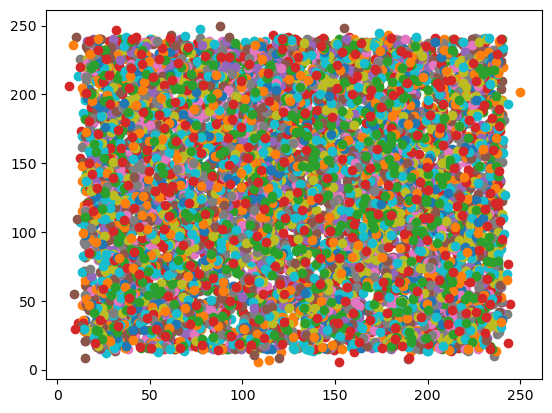

In [8]:
for i in range(6):
    num_crystals = [40, 80, 120, 200, 400, 600, 1200]
    simulations = [CrystalSTEMSimulation(Al_Structure, real_space_pixels=256, num_crystals=i) for i in num_crystals]
    with open("recall_crystals"+str(i)+".txt","w+") as f:
        f.write("num_crystals, perfect_recall, partial_recall \n")
        from skimage.draw import disk
        mask = np.ones((64,64), dtype=bool)
        rr,cc = disk((32,32), 10)
        mask[rr,cc]=False
        for s, num_crystal in zip(simulations,num_crystals):
            arr = s.make_4d_nano(num_electrons=10)
            ground_truth_vectors = s.vectors
            signal = hs.signals.Signal2D(arr)
            signal.set_signal_type("electron_diffraction")
            signal = signal.as_lazy()
            signal.rechunk((32,32))

            filtered = signal.filter(gaussian_filter, 
                         sigma=(1,1,0,0))
            template = filtered.template_match_disk(disk_r=5,
                                        subtract_min=False,
                                            show_progressbar=False)
            template.data[:,:,:, 0:5]=0
            template.data[:,:,:,-5:]=0
            template.data[:,:, 0:5, :]=0
            template.data[:,:,-5:, :]=0
            pks = template.find_peaks(threshold_abs=0.5,
                          interactive=False,
                          show_progressbar=False )
            vect = DiffractionVectors.from_peaks(pks,
                                     center= (32, 32),
                                     calibration=(1/32,1/32))
            vect.compute()
            filt = vect.filter_magnitude(.05,.85,show_progressbar=False )

            flat = filt.flatten_diffraction_vectors()
            signal.axes_manager.signal_axes[0].offset=-1
            signal.axes_manager.signal_axes[1].offset=-1
            signal.axes_manager.signal_axes[1].scale=1/32
            signal.axes_manager.signal_axes[0].scale=1/32
            
            flat = filt.flatten_diffraction_vectors()
            cords = s.get_coords(low=0.1, high=0.8)
            filtered_centers = s.centers[[len(c)>1 for c in cords]]
            lab = flat.cluster(DBSCAN(eps=1,min_samples=2 ), columns=[0,1,2,3],
                               column_scale_factors=[2,2,0.05,0.05])
            
            clust = lab.cluster_labeled_vectors(DBSCAN(eps=5, min_samples=2))            
            
            # Find the mean position in real space
            means = clust.map_vectors(column_mean,columns=[0, 1,],
                          label_index=-1,
                          dtype=float,
                          shape=(2,))
            
            # Find all of the Diffraction Vectors identified
            center_means = clust.map_vectors(get_vector_centers, dtype=object)
            
            # Get the coordinates for the all of the centers in real space and the coordinates in
            # reciporical space
            filtered_coords = s.get_coords(.1,0.8)
            filtered_centers = [cen for cen, c in zip(s.centers, filtered_coords) if len(c)>1]
            filtered_coords = [c for c in filtered_coords if len(c)>1]

            mean_tree= KDTree(means)
            # testing recall percentage
            in_range = [m for m in mean_tree.query_ball_point(filtered_centers, r=4)]

            recall_percents =[]
            for ground_truth, ind in zip(filtered_coords, in_range):
                gt_tree = KDTree(ground_truth[:,:2])
                recall_percent = []
                for i in ind:
                    inside = np.sum([len(r)>0 for r in gt_tree.query_ball_point(center_means[i][:,:2], r=0.1)])
                    recall_percent.append(inside/len(ground_truth))

                if len(recall_percent)==0:
                    recall_percents.append(np.nan)
                else:
                    recall_percents.append(np.max(recall_percent))
            unique, counts = np.unique(recall_percents, return_counts=True)
            
            filtered_centers = np.array(filtered_centers)
            plt.scatter(filtered_centers[:,0],filtered_centers[:,1])
            plt.scatter(means[:,0],means[:,1])
            print(unique, counts)
            perfect_recall_percent = np.sum(counts[unique>=1])/np.sum(counts)
            print("Perfect Recall", perfect_recall_percent)
            partial_recall_percent = np.sum(counts[unique>0])/np.sum(counts)
            print("Partial Recall", partial_recall_percent)
            f.write(str(num_crystal)+", " + str(perfect_recall_percent)+", "+ str(partial_recall_percent)+"\n")